# MVA - Computational Optimal Transport Project - Eugène Berta

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal, uniform
from tqdm import tqdm

Some of the code in this notebook is directly inspired from the numerical tours of data science on optimal transport, see https://www.numerical-tours.com/python/ for the original.

# 1. Discrete case :

## 1.1 Generating data

In [2]:
myplot = lambda x,y,ms,col: plt.scatter(x,y, s=ms*15, edgecolors="k", c=col, linewidths=2)

In [3]:
def plot_distrib(x, y, a, b):
    for i in range(len(a)):
        myplot(x[i,0], x[i,1], a[i]*len(a)*10, 'b')
    for j in range(len(b)):
        myplot(y[j,0], y[j,1], b[j]*len(b)*10, 'r')
    plt.axis("off")

In [4]:
def plot_P(P, x, y, a, b, bold=1):
    """
    A function to plot an optimal transport plan P, together with the associated discrete distributions.
    """
    for i in range(len(a)):
        myplot(x[i,0], x[i,1], a[i]*len(a)*10, 'b')
    for j in range(len(b)):
        myplot(y[j,0], y[j,1], b[j]*len(b)*10, 'r')

    #A = P > np.repeat(np.sum(P, axis=1, keepdims=True), len(P[0]), axis=1)*0.8
    A = P * (P > np.amax(P)*.8)
    i,j = np.where(A != 0)
    plt.plot([x[i,0],y[j,0]],[x[i,1],y[j,1]],'k',lw=3*bold, alpha=0.8)

    #A = P > np.repeat(np.sum(P, axis=1, keepdims=True), len(P[0]), axis=1)*0.5
    A = P * (P > np.amax(P)*.4)
    i,j = np.where(A != 0)
    plt.plot([x[i,0],y[j,0]],[x[i,1],y[j,1]],'k',lw=2*bold, alpha=0.5)

    #A = P > np.repeat(np.sum(P, axis=1, keepdims=True), len(P[0]), axis=1)*0.2
    A = P * (P > np.amax(P)*.2)
    i,j = np.where(A != 0)
    plt.plot([x[i,0],y[j,0]],[x[i,1],y[j,1]],'k',lw=1*bold, alpha=0.2)

    plt.axis("off")

### Toy example

In [5]:
x_toy = np.hstack((np.arange(0,2.5,0.5).reshape(-1,1), np.zeros((5,1))))
y_toy = np.hstack((np.arange(0,2.5,0.5).reshape(-1,1)+0.5, 0.5*np.ones((5,1))))

a_toy = np.ones(5)/5
b_toy = np.ones(5)/5

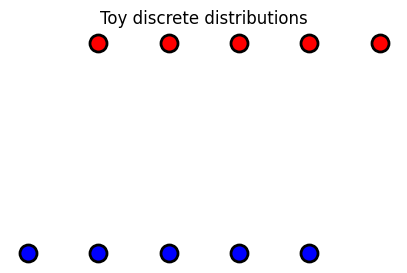

In [7]:
plt.figure(figsize=(5,3))
plt.title("Toy discrete distributions")
plot_distrib(x_toy, y_toy, a_toy, b_toy)

### Complex example

In [9]:
N = [150,100]
d=2

thetax = np.pi*np.random.rand(N[0], 1)
rx = .8 + .2*np.random.rand(N[0], 1)
thetay = -np.pi*np.random.rand(N[1], 1)
ry = .8 + .2*np.random.rand(N[1], 1)

x = np.hstack((np.cos(thetax)*rx + 0.5, np.sin(thetax)*rx))
y = np.hstack((np.cos(thetay)*ry - 0.5, np.sin(thetay)*ry))

normalize = lambda a: a/np.sum(a)
a = normalize(0.5+np.random.rand(N[0]))
b = normalize(0.5+np.random.rand(N[1]))

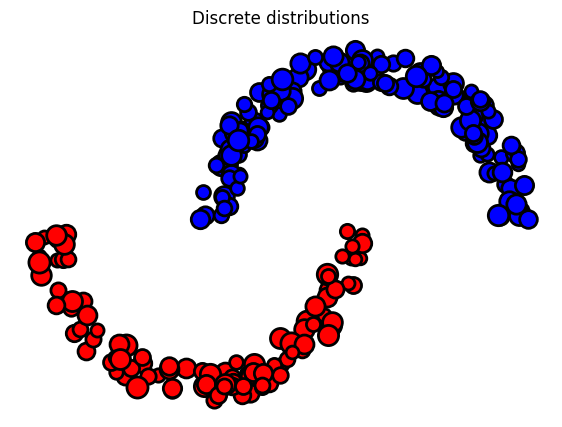

In [10]:
plt.figure(figsize=(7,5))
plt.title("Discrete distributions")
plot_distrib(x, y, a, b)

## 1.1 Computing OT by solving the primal :

In [11]:
def compute_cost(x, y):
    """
    A function to compute the discrete cost C using 2-wasserstein distance between discrete distributions.
    """
    x_tile = np.tile(x[:, np.newaxis], (len(y), 1))
    y_tile = np.tile(y[:, np.newaxis], (len(x), 1)).transpose((1,0,2))
    C = np.sum(np.square(x_tile-y_tile), axis=2)
    return C

### Toy example :

In [12]:
# Convex problem
C_toy = compute_cost(x_toy, y_toy)
P_toy = cp.Variable((5,5))

u = np.ones(5)
v = np.ones(5)
U = [0 <= P_toy, cp.matmul(P_toy,u)==a_toy, cp.matmul(P_toy.T,v)==b_toy]

# Optimization
objective = cp.Minimize(cp.sum(cp.multiply(P_toy,C_toy)))
prob = cp.Problem(objective, U)
result = prob.solve()

# Result
P_toy_OT = P_toy.value

In [13]:
print(f"Cost = {np.multiply(P_toy_OT, C_toy).sum():.4f}")

Cost = 0.5000


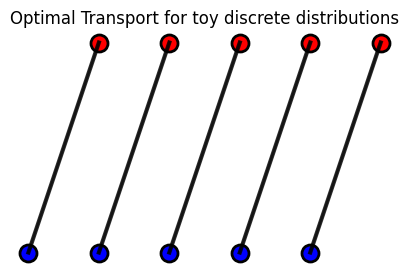

In [14]:
plt.figure(figsize=(5,3))
plt.title("Optimal Transport for toy discrete distributions")
plot_P(P_toy_OT, x_toy, y_toy, a_toy, b_toy)

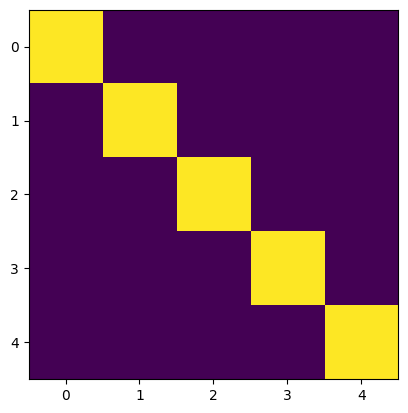

In [15]:
plt.imshow(P_toy_OT)
plt.show()

### Complex data :

In [16]:
C = compute_cost(x, y)
P = cp.Variable(N)

u = np.ones(N[1])
v = np.ones(N[0])
U = [0 <= P, cp.matmul(P,u)==a, cp.matmul(P.T,v)==b]

objective = cp.Minimize(cp.sum(cp.multiply(P,C)))
prob = cp.Problem(objective, U)
result = prob.solve()

P_OT = P.value

In [17]:
print(f"Cost = {np.multiply(P_OT, C).sum():.4f}")

Cost = 2.5960


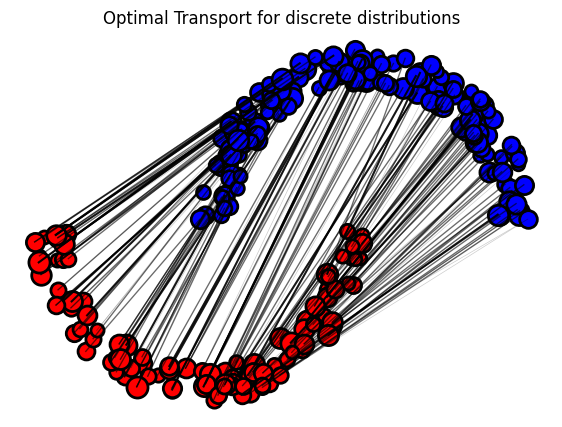

In [18]:
plt.figure(figsize=(7, 5))
plt.title("Optimal Transport for discrete distributions")
plot_P(P_OT, x, y, a, b, bold=0.5)

## 1.2 Computing $OT$ with SAG-OT :

Case 1 : $\epsilon = 0$ 

In [19]:
def Xi(Ci, v):
    Xi = np.zeros_like(v)
    Xi[np.argmin(Ci-v)] = 1
    return Xi

def Grad_h(C, i, v, b):
    return b - Xi(C[i], v)

def v_c(C, v):
    """
    c transform
    """
    I, J = C.shape
    return np.min(C - np.repeat(v.reshape(-1,1), I, axis=1).transpose(), axis=1)

def SAG_OT(C, a, b, n_iter, step_size, figure=True):
    """
    Function to use when eps=0
    """
    I, J = C.shape
    v = np.zeros(J)
    mean_grad = np.zeros(J)
    g = np.zeros((I, J))

    grad_norm = np.zeros(n_iter)
    v_seq = np.zeros((n_iter, J))
    for k in range(n_iter):
        i = np.random.randint(I)
        mean_grad -= g[i]
        g[i] = a[i]*Grad_h(C, i, v, b)
        mean_grad += g[i]
        v += step_size*mean_grad

        grad_norm[k] = np.linalg.norm(mean_grad, ord=1)
        v_seq[k] = v
    
    if figure:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title(r"$||\sum_{i \in I}\nabla h_\epsilon(x_i,v)\mu_i||_1$")
        plt.plot(grad_norm)

        plt.subplot(122)
        plt.title(r"$||v - v^*||_1$")
        v_star = v_seq[-1]
        plt.plot(np.linalg.norm(v_seq-v_star, ord=1, axis=1)/np.linalg.norm(v_star, ord=1))
        plt.show()

    u = v_c(C, v)
    print(f"Cost = {np.dot(u,a) + np.dot(v,b):.4f}")

### Toy Example

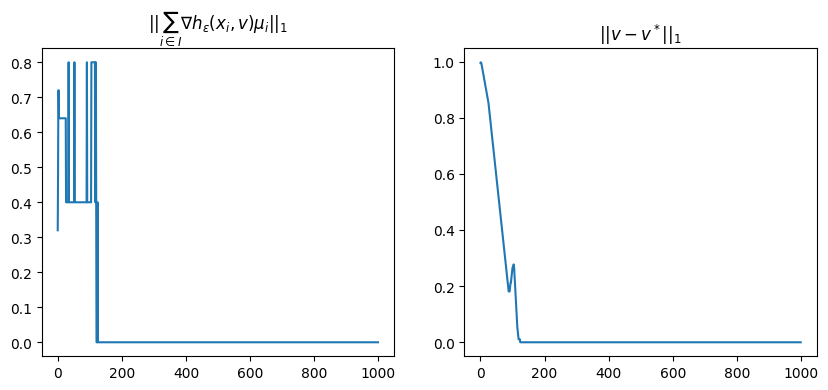

Cost = 0.5000


In [21]:
SAG_OT(C_toy, a_toy, b_toy, n_iter=1000, step_size=0.05, figure=True)

The algorithm converges, and the cost computed is the same.

### Complex Data

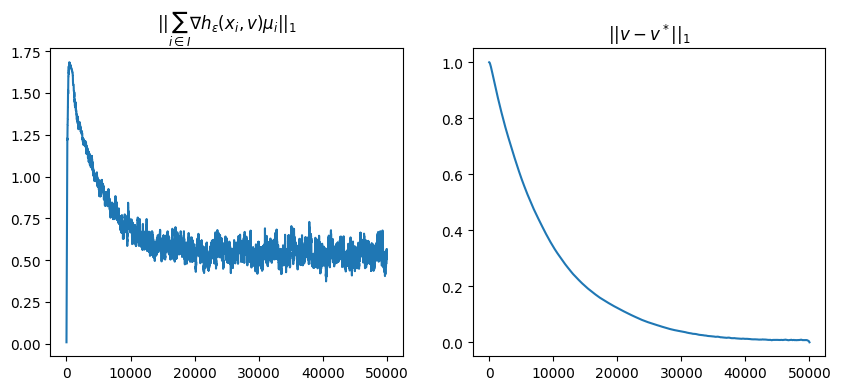

Cost = 2.5908


In [22]:
SAG_OT(C, a, b, n_iter=50000, step_size=0.01, figure=True)

Results looks satisfying but open question : **how to compute P from u and v when epsilon=0 ?**

We can use the dual vectors to compute the OT cost but not the optimal transport and it gradients, we loose some expressive power ?

## 1.3 Computing $OT_\epsilon$ with Sinkhorn algorithm :

In [23]:
def Sinkhorn(C, a, b, eps, n_iter, figure=True):
    I, J = C.shape
    K = np.exp(-C/eps)
    v = np.ones(J)

    Err_p = np.zeros(n_iter)
    Err_q = np.zeros(n_iter)
    v_seq = np.zeros((n_iter, J))
    for k in range(n_iter):
        # Step 1:
        u = a / np.dot(K,v)
        Err_q[k] = np.linalg.norm(v*np.dot(np.transpose(K),u) - b, 1)
        # Step 2:
        v = b / np.dot(np.transpose(K),u)
        Err_p[k] = np.linalg.norm(u*np.dot(K,v) - a,1)

        v_seq[k] = v
    
    P_Sink = np.dot(np.dot(np.diag(u),K),np.diag(v))

    if figure:
        plt.figure(figsize = (10,4))
        plt.subplot(2,2,1)
        plt.title(r"$||P 1 - a||$")
        plt.plot(np.log(np.asarray(Err_p)), linewidth = 2)
        plt.subplot(2,2,3)
        plt.title(r"$||P^T 1 - b||$")
        plt.plot(np.log(np.asarray(Err_q)), linewidth = 2)
        
        plt.subplot(2,2,(2,4))
        plt.title(r"$||v - v^*||_1$")
        v_star = v_seq[-1]
        plt.plot(np.linalg.norm(v_seq-v_star, ord=1, axis=1)/np.linalg.norm(v_star, ord=1))
        
        plt.tight_layout()
        plt.show()
    
    print(f"Cost = {np.multiply(P_Sink, C).sum():.4f}")

    return P_Sink

### Toy example

In [24]:
eps = .01

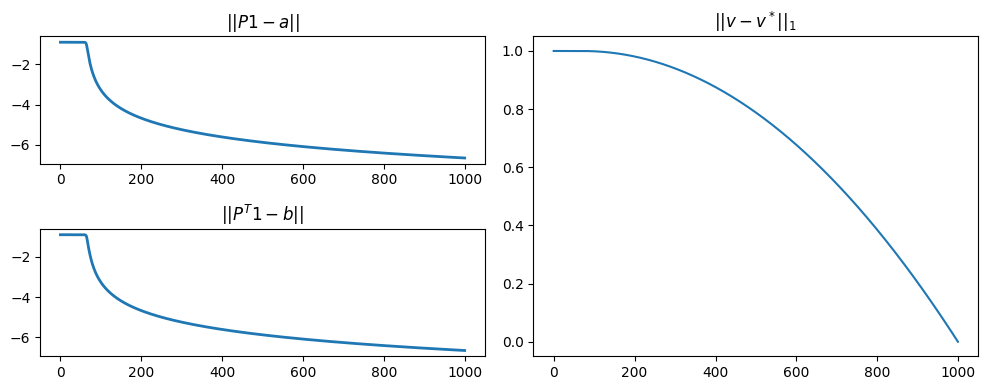

Cost = 0.4995


In [25]:
P_toy_Sink = Sinkhorn(C_toy, a_toy, b_toy, eps, n_iter=1000)

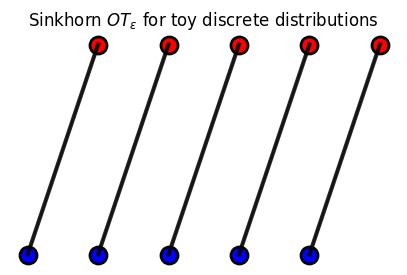

In [26]:
plt.figure(figsize=(5,3))
plt.title(r"Sinkhorn $OT_\epsilon$ for toy discrete distributions")
plot_P(P_toy_Sink, x_toy, y_toy, a_toy, b_toy)

### Complex data

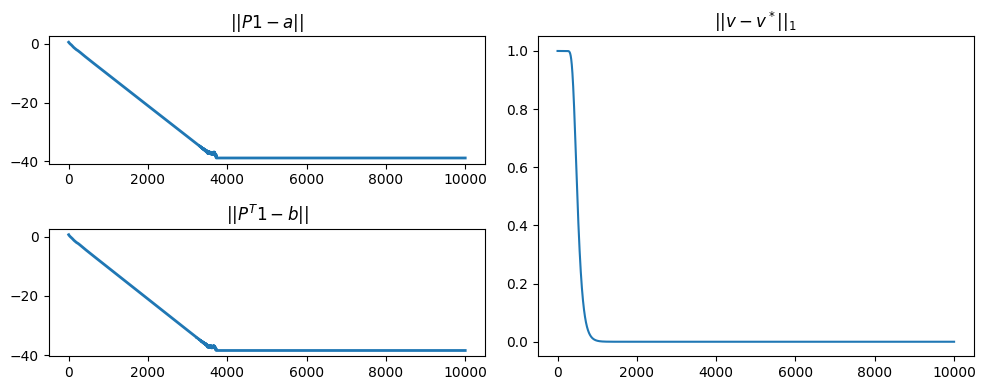

Cost = 2.6022


In [27]:
P_Sink = Sinkhorn(C, a, b, eps, n_iter=10000)

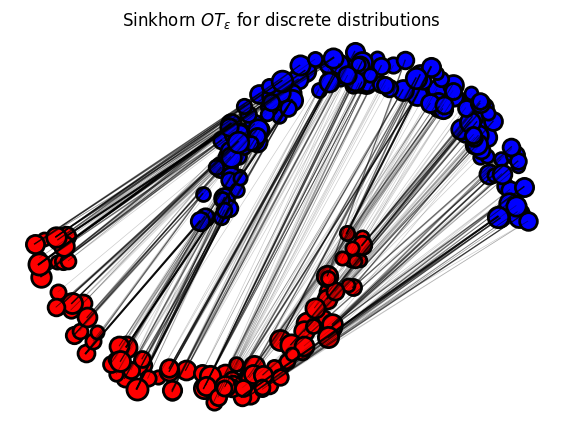

In [28]:
plt.figure(figsize=(7,5))
plt.title("Sinkhorn $OT_\epsilon$ for discrete distributions")
plot_P(P_Sink, x, y, a, b, bold=0.5)

## 1.4 Computing $OT_\epsilon$ with SAG-$OT_\epsilon$ :

Case 2 : $\epsilon > 0$

In [29]:
def Xi_eps(r, b, eps):
    Xi = np.multiply(np.exp(-r/eps), b)
    return Xi / Xi.sum()

def Grad_h_eps(i, v, C, b, eps):
    return b - Xi_eps(C[i]-v, b, eps)

def v_c_eps(v, C, a, b, eps):
    """
    eps smooth c-transform
    """
    I, J = C.shape
    u = np.zeros(I)
    for i in range(I):
        u[i] = -eps*np.log(np.dot(np.exp((v - C[i])/eps), b))
    return u

def P_from_u_v(u, v, C, a, b, eps):
    """
    Function to recover the solution of the primal.
    """
    I, J = C.shape
    u_tile = np.tile(u[:, np.newaxis], (1, J))
    a_tile = np.tile(a[:, np.newaxis], (1, J))
    v_tile = np.tile(v, (I,1))
    b_tile = np.tile(b, (I,1))
    return np.multiply(np.exp((u_tile + v_tile - C)/eps), np.multiply(a_tile, b_tile))

def SAG_OTe(C, a, b, eps, n_iter, step_size, figure=True):
    I, J = C.shape
    v = np.zeros(J)
    mean_grad = np.zeros(J)
    g = np.zeros((I, J))

    grad_norm = np.zeros(n_iter)
    v_seq = np.zeros((n_iter, J))
    for k in range(n_iter):
        i = np.random.randint(I)
        mean_grad -= g[i]
        g[i] = a[i]*Grad_h_eps(i, v, C, b, eps)
        mean_grad += g[i]
        v += step_size*mean_grad

        grad_norm[k] = np.linalg.norm(mean_grad, ord=1)
        v_seq[k] = v
    
    if figure:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title(r"$||\sum_{i \in I}\nabla h_\epsilon(x_i,v)\mu_i||_1$")
        plt.plot(grad_norm)

        plt.subplot(122)
        plt.title(r"$||v - v^*||_1$")
        v_star = v_seq[-1]
        plt.plot(np.linalg.norm(v_seq-v_star, ord=1, axis=1)/np.linalg.norm(v_star, ord=1))
        plt.show()

    u = v_c_eps(v, C, a, b, eps)
    P_SAG = P_from_u_v(u, v, C, a, b, eps)
    #print(f"Cost = {np.dot(u,a) + np.dot(v,b):.4f}")
    print(f"Cost = {np.multiply(P_SAG, C).sum():.4f}")
    return P_SAG

### Toy example

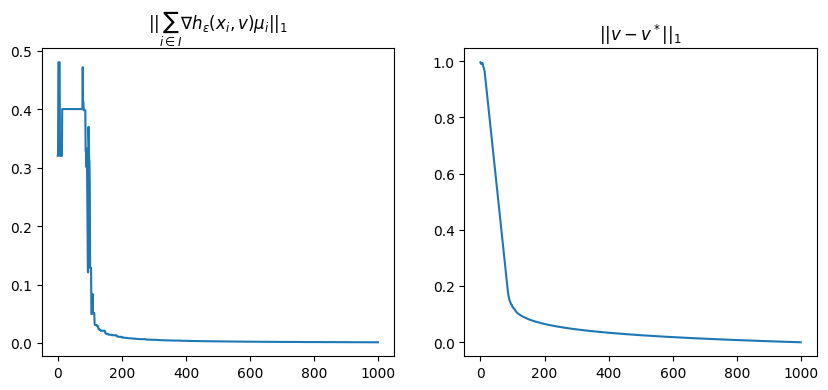

Cost = 0.4995


In [30]:
P_toy_SAG = SAG_OTe(C_toy, a_toy, b_toy, eps, n_iter=1000, step_size=.05)

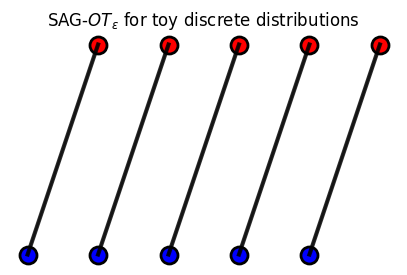

In [31]:
plt.figure(figsize=(5,3))
plt.title(r"SAG-$OT_\epsilon$ for toy discrete distributions")
plot_P(P_toy_SAG, x_toy, y_toy, a_toy, b_toy)

### Complex data

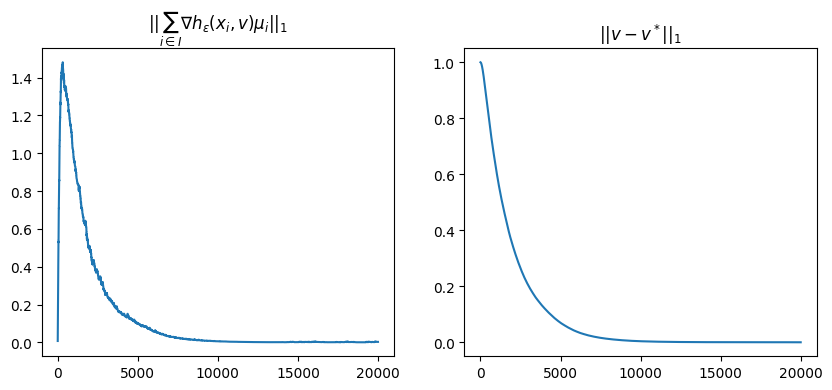

Cost = 2.6029


In [32]:
P_SAG = SAG_OTe(C, a, b, eps, n_iter=20000, step_size=.05)

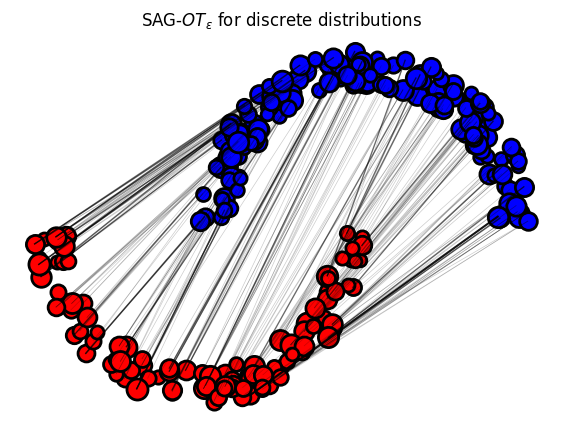

In [33]:
plt.figure(figsize=(7,5))
plt.title(r"SAG-$OT_\epsilon$ for discrete distributions")
plot_P(P_SAG, x, y, a, b, bold=0.5)

## 1.5 Comparing results :

In [34]:
print(f"{np.linalg.norm(P_Sink-P_OT):.5f}")
print(f"{np.linalg.norm(P_SAG-P_OT):.5f}")
print(f"{np.linalg.norm(P_Sink-P_SAG):.5f}")

0.06080
0.06105
0.00390


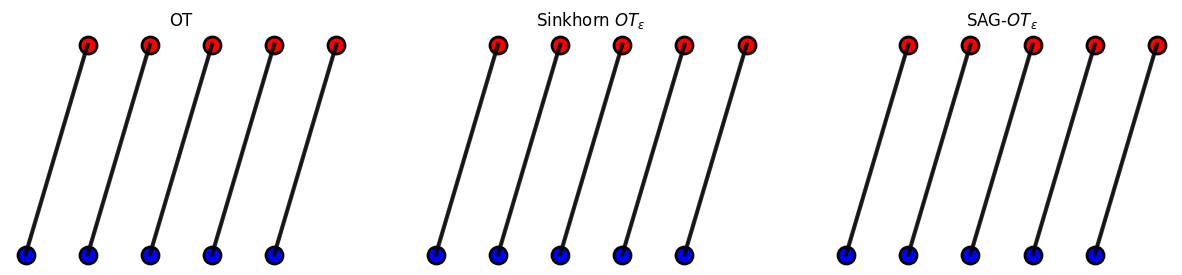

In [35]:
plt.figure(figsize=(15,3))

ax1 = plt.subplot(131)
ax1.set_title("OT")
plot_P(P_toy_OT, x_toy, y_toy, a_toy, b_toy)

ax2 = plt.subplot(132)
ax2.set_title(r"Sinkhorn $OT_\epsilon$")
plot_P(P_toy_Sink, x_toy, y_toy, a_toy, b_toy)

ax3 = plt.subplot(133)
ax3.set_title(r"SAG-$OT_\epsilon$")
plot_P(P_toy_SAG, x_toy, y_toy, a_toy, b_toy)

plt.show()

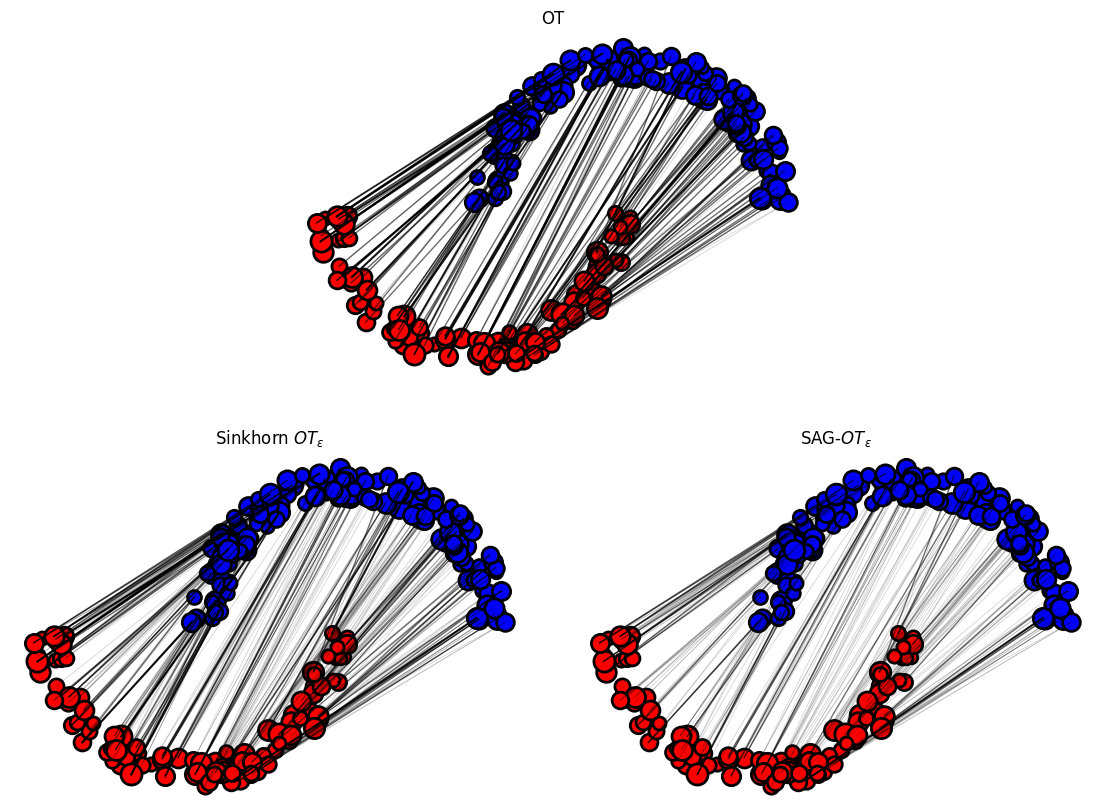

In [36]:
bold=0.5

plt.figure(figsize=(14,10))

ax1 = plt.subplot(2,4,(2,3))
ax1.set_title("OT")
plot_P(P_OT, x, y, a, b, bold)

ax3 = plt.subplot(2,4,(5,6))
ax3.set_title(r"Sinkhorn $OT_\epsilon$")
plot_P(P_Sink, x, y, a, b, bold)

ax4 = plt.subplot(2,4,(7,8))
ax4.set_title(r"SAG-$OT_\epsilon$")
plot_P(P_SAG, x, y, a, b, bold)

plt.show()

We observe that the regularized solution is slightly less sparse. We see the effect of the regularization term.

# 2. Semi-Discrete case :

## 2.1 Generating the data

In [37]:
def plot_semi_discrete(x, y, b):
    """
    Function to plot continuous distribution x and discrete distrbution (y,b)
    """
    p = 300
    t = np.linspace(0, 1, p)
    [V, U] = np.meshgrid(t, t)
    grid = np.stack([V, U], axis=2)
    a = x.pdf(grid)
    plt.figure(figsize = (5,5))
    plt.axis("off")

    plt.imshow(-a[::-1, :], extent=[0, 1, 0, 1], cmap='gray')
    for i in range(len(b)):
        myplot(y[i, 0], y[i, 1], b[i]*len(b)*10, 'r')
    plt.show()

### Toy Example

In [38]:
# mu
x_toy = multivariate_normal(mean=np.array([.5, .5]), cov=0.01)

# nu
y_toy = np.array([[0.1,0.5], [0.9,0.5]])
b_toy = np.array([0.5, 0.5])

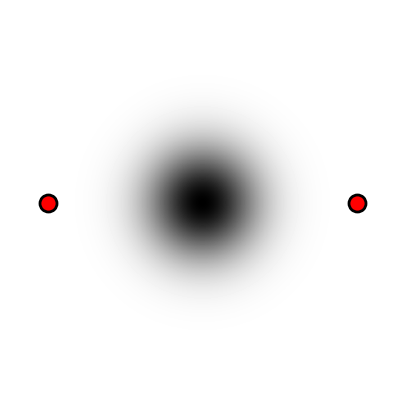

In [39]:
plot_semi_discrete(x_toy, y_toy, b_toy)

### Example 1

In [40]:
# mu
x1 = multivariate_normal(mean=np.array([.5, .5]), cov=0.01)

# nu
N = 20
r = .4
theta = 2*np.pi*np.random.rand(N, 1)
y1 = np.hstack((np.cos(theta)*r + 0.5, np.sin(theta)*r + 0.5))
b1 = np.ones(N)/N

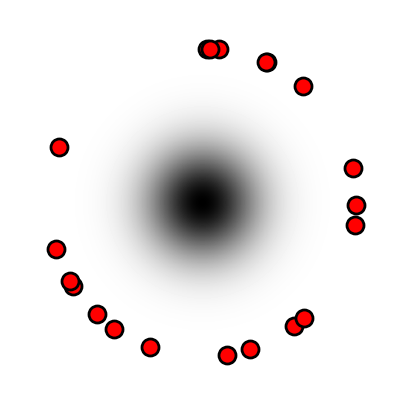

In [41]:
plot_semi_discrete(x1, y1, b1)

### Implementing the SGD

In [42]:
def Grad_h_SGD(x, y, v, b, eps):
    c_xy = np.sum(np.square(y-x), axis=-1)
    return b - Xi_eps(c_xy-v, b, eps)

def Averaged_SGD(x, y, b, eps, n_iter, step_size, figure=True):
    J = len(y)
    f_seq = np.zeros((n_iter, J))
    
    f, f_til = np.zeros(J), np.zeros(J)
    grad_norm = np.zeros(n_iter)
    for k in range(n_iter):       
        # gradient
        x_k = x.rvs()
        grad = Grad_h_SGD(x_k, y, f_til, b, eps)
        f_til += grad*step_size/np.sqrt(k+1)
        f = f_til/(k+1) + f*(k/n_iter)
        grad_norm[k] = np.linalg.norm(grad)
        f_seq[k] = f

    f_star = f_seq[-1]

    if figure:
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title(r"$||\sum_{i \in I}\nabla h_\epsilon(x_i,v)\mu_i||_1$")
        plt.plot(grad_norm)

        plt.subplot(122)
        plt.title(r"$||v - v^*||_1$")
        plt.plot(np.linalg.norm(f_seq-f_star, ord=1, axis=1)/np.linalg.norm(f_star, ord=1))
        plt.show()

    return f_star

### Toy example

In [43]:
eps=.01

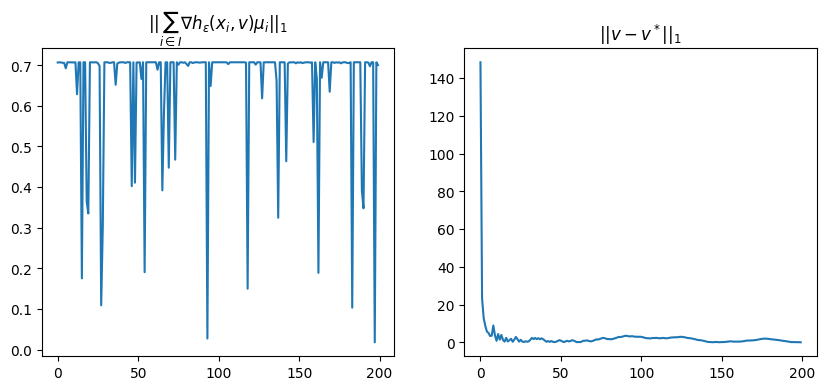

In [44]:
f_star = Averaged_SGD(x_toy, y_toy, b_toy, eps, n_iter=200, step_size=0.1)

### Complex example

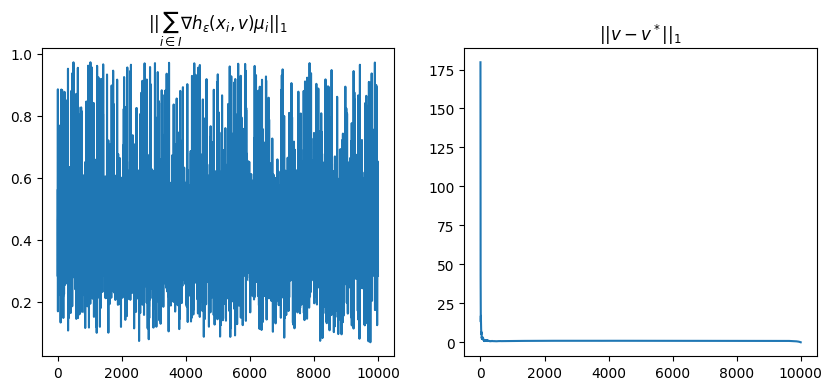

In [45]:
f_star = Averaged_SGD(x1, y1, b1, eps, n_iter=10000, step_size=0.1)

We compare the results with the discrete-discrete version :

In [46]:
x1_sample = x1.rvs(200)
a1_sample = np.ones(200)/200

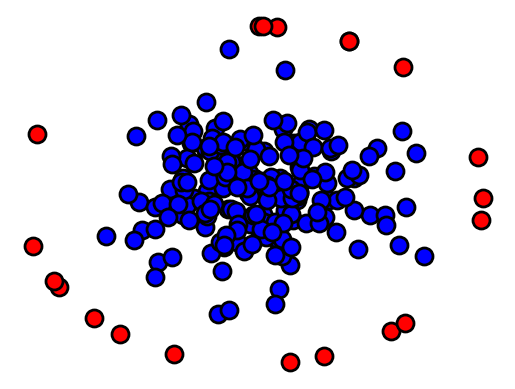

In [47]:
plot_distrib(x1_sample, y1, a1_sample, b1)

In [48]:
C1 = compute_cost(x1_sample, y1)

In [49]:
g_star = v_c_eps(f_star, C1, a1_sample, b1, eps)
P1_semi_discrete = P_from_u_v(g_star, f_star, C1, a1_sample, b1, eps)

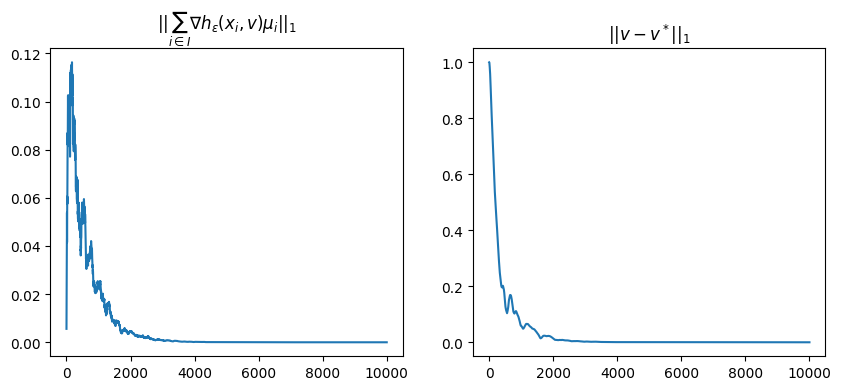

Cost = 0.0892


In [52]:
P1_discrete = SAG_OTe(C1, a1_sample, b1, eps, n_iter=10000, step_size=.01)

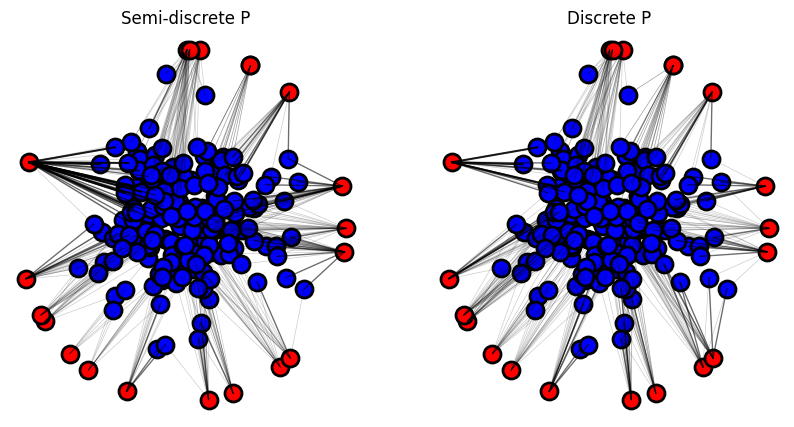

In [53]:
plt.figure(figsize=(10,5))
bold=0.5

ax1 = plt.subplot(121)
ax1.set_title(r"Semi-discrete P")
plot_P(P1_semi_discrete, x1_sample, y1, a1_sample, b1, bold)

ax2 = plt.subplot(122)
ax2.set_title(r"Discrete P")
plot_P(P1_discrete, x1_sample, y1, a1_sample, b1, bold)

plt.show()

In [54]:
np.linalg.norm(P1_discrete - P1_semi_discrete, ord=1)

0.059927146487450005

# 3. Continuous - Continuous case

Toy example : two gaussians, we know the optimal transport and can compute it in closed form. Can be re-written in the paper to add some content.

In [55]:
def kernel_SGD(c, kernel, mu, nu, eps, num_steps):
    step_size = 1e-2
    x, y, alpha = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)

    x[0] = mu.rvs()
    y[0] = nu.rvs()
    alpha[0] = step_size * (1 - np.exp(-c(x[0], y[0])/eps))

    for k in range(1, num_steps):
        x[k] = mu.rvs()
        y[k] = nu.rvs()
        u = np.dot(alpha[:k], kernel(x[k], x[:k]))
        v = np.dot(alpha[:k], kernel(y[k], y[:k]))        
        alpha[k] = (step_size/np.sqrt(k+1)) * (1 - np.exp((u + v - c(x[k], y[k]))/eps))
    return alpha, x, y

In [56]:
def c(x, y):
    return np.square(x-y).mean()

In [57]:
def kernel(x, y, sigma=0.2):
    return np.exp(-np.square(x-y)/(sigma**2))

In [58]:
def approx_u(t, alpha, x):
    return np.dot(alpha, kernel(t, x))

def approx_v(t, alpha, y):
    return np.dot(alpha, kernel(t, y))

In [60]:
def continuous_wasserstein(mu, nu, c, eps, n_samples):
    """
    Compute the 2-Wassertein distance between continuous distributions mu and nu using kernel SGD.
    """
    alpha, x, y = kernel_SGD(c, kernel, mu, nu, eps, num_steps=int(1e4))
    
    samples_mu = mu.rvs(n_samples)
    samples_nu = nu.rvs(n_samples)

    w = 0
    for i in range(n_samples):
        u = approx_u(samples_mu[i], alpha, x)
        v = approx_v(samples_nu[i], alpha, y)
        w += u + v - eps*np.exp((u + v - c(samples_mu[i], samples_nu[i]))/eps)
    
    return w/n_samples

In [61]:
mu = norm(loc=0, scale=0.1)
nu = norm(loc=1, scale=0.1)

In [62]:
continuous_wasserstein(mu, nu, c, eps=0.1, n_samples=1000)

0.8617661588871335

In [63]:
def bures_wasserstein(mu_mean, mu_sigma, nu_mean, nu_sigma):
    """
    Compute the 2-Wassertein distance between continuous distributions mu and nu using closed form.
    """
    return np.square(mu_mean - nu_mean) + np.square(mu_sigma - nu_sigma)

In [64]:
# DENSITY FITTING EXPERIMENT:
start_mean = 0
start_sigma = 0.2

stop_mean = 4
stop_sigma = 0.2

nu = norm(loc=2, scale=0.2)

w_true = []
w_cont = []
num_steps = 50
for i in tqdm(range(num_steps+1)):
    mean = ((num_steps-i)*start_mean + i*stop_mean)/num_steps
    sigma = ((num_steps-i)*start_sigma + i*stop_sigma)/num_steps

    mu = norm(loc=mean, scale=sigma)

    w_true.append(bures_wasserstein(mean, sigma, 2, 0.2))
    w_cont.append(continuous_wasserstein(mu, nu, c, eps=0.1, n_samples=int(1e4)))

100%|██████████| 51/51 [03:06<00:00,  3.66s/it]


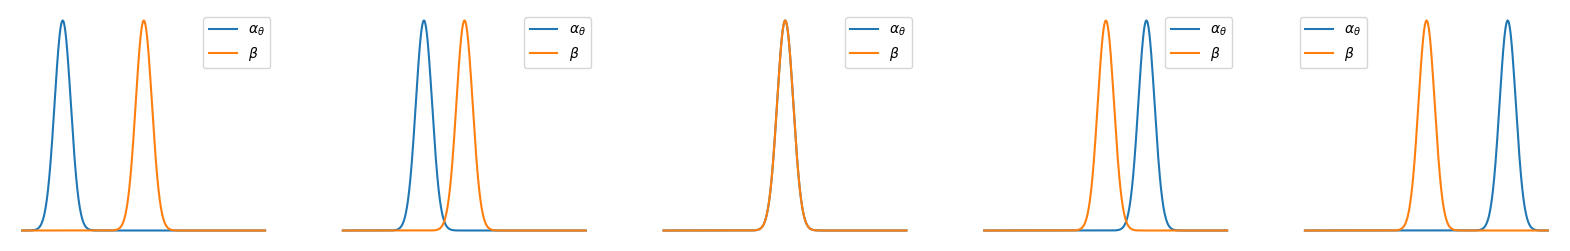

In [65]:
# ILLUSTRATING THE EXPERIMENT:
nu = norm(loc=2, scale=0.2)

plt.figure(figsize=(20,3))
for i in range(5):
    mu = norm(loc=i, scale=0.2)
    ax = plt.subplot(1,5,i+1)
    ax.plot(np.arange(-1, 5, 1e-2), mu.pdf(np.arange(-1, 5, 1e-2)), label=r"$\alpha_\theta$")
    ax.plot(np.arange(-1, 5, 1e-2), nu.pdf(np.arange(-1, 5, 1e-2)), label=r"$\beta$")
    ax.legend()
    ax.axis("off")
plt.show()

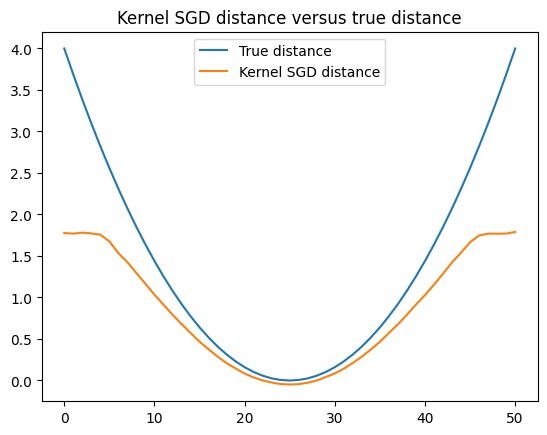

In [66]:
plt.title("Kernel SGD distance versus true distance")
plt.plot(range(len(w_true)), w_true, label="True distance")
plt.plot(range(len(w_cont)), w_cont, label="Kernel SGD distance")
plt.legend()
plt.show()

## Figures for the slides :

Discrete example :

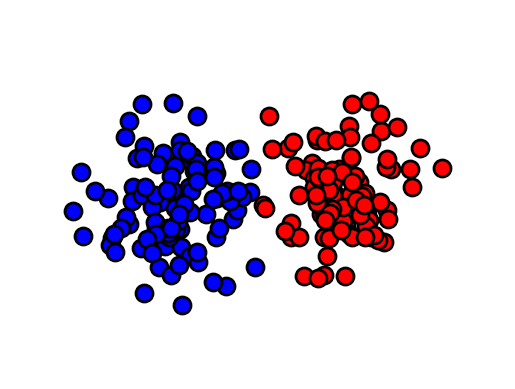

In [67]:
a = multivariate_normal(mean=[0,0], cov=0.05)
x = a.rvs(100)

b = multivariate_normal(mean=[1,0], cov=0.05)
y = b.rvs(100)

for i in range(len(x)):
    myplot(x[i,0], x[i,1], 10, 'b')

for i in range(len(y)):
    myplot(y[i,0], y[i,1], 10, 'r')

plt.axis([-1, 2, -1, 1])
plt.axis("off")
plt.show()

Semi-discrete example :

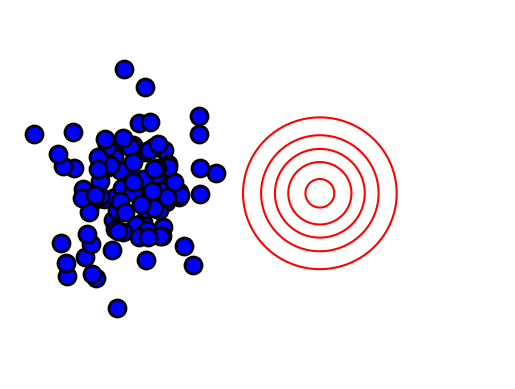

In [68]:
a = multivariate_normal(mean=[0,0], cov=0.05)
x = a.rvs(100)

b = multivariate_normal(mean=[1,0], cov=0.05)

for i in range(len(x)):
    myplot(x[i,0], x[i,1], 10, 'b')


x = np.arange(0, 2, 0.01)
y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(x, y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
plt.contour(X, Y, b.pdf(pos), levels=5, colors="red")

# plt.axis([-1, 2, -1, 1])
plt.axis("off")
plt.show()

Continuous example :

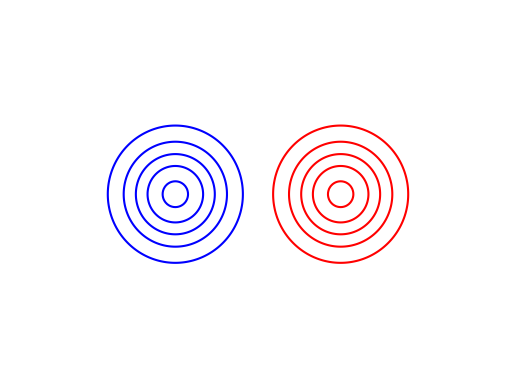

In [69]:
a = multivariate_normal(mean=[0,0], cov=0.05)
b = multivariate_normal(mean=[1,0], cov=0.05)

x = np.arange(-1, 1, 0.01)
y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(x, y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
plt.contour(X, Y, a.pdf(pos), levels=5, colors="blue")

x = np.arange(0, 2, 0.01)
y = np.arange(-1, 1, 0.01)
X, Y = np.meshgrid(x, y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y
plt.contour(X, Y, b.pdf(pos), levels=5, colors="red")

plt.axis([-1, 2, -1.1, 1.1])
plt.axis("off")
plt.show()